# Build a custom OpenAI Gym environment
> Learn how to build a custom OpenAI Gym environment.

- toc: false
- badges: true
- comments: true
- author: dzlab
- categories: [tensorflow, reinforcement]


OpenAI Gym is a comprehensive platform for building and testing RL strategies. It comes will a lot of ready to use environments but in some case when you're trying a solve specific problem and cannot use off the shelf environments. In this case, you can still leverage Gym to build a custom environment and this post walks through how to do it.

As an example, we will build a GridWorld environment with the following rules:

Each cell of this environment can have one of the following colors:
- **BLUE**: a cell reprensentig the agent
- **GREEN**: a cell reprensentig the target destination
- **GRAY**: a cell representing a wall
- **RED**: a cell representing a bomb
- **BLACK**: an empty cell

In this environment, the agent can move UP, DOWN, LEFT or RIGHT. The agent get rewarded dependening on the cell color where the move will take it:
- `0.0` if the agent moves into an empty cell (i.e. **BLACK** cell)
- `-0.1` if the agent hits a cell containing a wall (i.e. **GRAY** cell)
- `-1.0` if the agent hits a cell containing a bomb (i.e. **RED** cell)
- `1.0` if the agent hits a cell containing the destinaton (i.e. **GREEN** cell)


The following picture depicts how the GridWorld environment looks like:

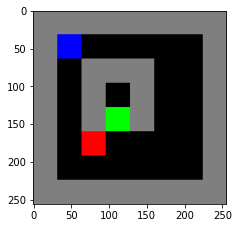

First, we need to install Gym and its dependencies to be able to use it and run it on a notebook:

In [1]:
%%capture
%%bash

apt install xvfb
pip install gym
pip install gym-notebook-wrapper

In [2]:
from collections import defaultdict
import copy
import sys
import numpy as np
import gnwrapper
import gym

Second, we declare the constants to represent cells type as well as the type of the agent actions: 

In [ ]:
# Grid cell state and color mapping
EMPTY = BLACK = 0
WALL = GRAY = 1
AGENT = BLUE = 2
BOMB = RED = 3
GOAL = GREEN = 4

# RGB color value table
COLOR_MAP = {
    BLACK: [0.0, 0.0, 0.0],
    GRAY: [0.5, 0.5, 0.5],
    BLUE: [0.0, 0.0, 1.0],
    RED: [1.0, 0.0, 0.0],
    GREEN: [0.0, 1.0, 0.0],
}

# Action mapping
NOOP = 0
DOWN = 1
UP = 2
LEFT = 3
RIGHT = 4

We can randomly initiate a grid to use on each episode, but for simplicity we initiate the grid to the same configuration as follows:

In [ ]:
DEFAULT_GRID_LAYOUT = """
        1 1 1 1 1 1 1 1
        1 2 0 0 0 0 0 1
        1 0 1 1 1 0 0 1
        1 0 1 0 1 0 0 1
        1 0 1 4 1 0 0 1
        1 0 3 0 0 0 0 1
        1 0 0 0 0 0 0 1
        1 1 1 1 1 1 1 1
        """

Then, we define the memory representation of the environment state using the following `State` class.

In [ ]:
class State:
    def __init__(self, grid_layout=DEFAULT_GRID_LAYOUT, max_steps=100):
        self.grid_layout = DEFAULT_GRID_LAYOUT
        self.initial_grid_state = np.fromstring(self.grid_layout, dtype=int, sep=" ")
        self.initial_grid_state = self.initial_grid_state.reshape(8, 8)
        self.grid_state = copy.deepcopy(self.initial_grid_state)
        self.action_pos_dict = defaultdict(
            lambda: [0, 0],
            {
                NOOP: [0, 0],
                UP: [-1, 0],
                DOWN: [1, 0],
                LEFT: [0, -1],
                RIGHT: [0, 1],
            },
        )
        (self.agent_state, self.goal_state) = self.get_state()
        self.done = False
        self.info = {"status": "Live"}
        self.step_num = 0  # To keep track of number of steps
        self.max_steps = max_steps

    def get_shape(self):
        return self.grid_state.shape

    def get_state(self):
        """Get the agent's position, as well as the goal's position
        """
        start_state = np.where(self.grid_state == AGENT)
        goal_state = np.where(self.grid_state == GOAL)

        start_or_goal_not_found = not (start_state[0] and goal_state[0])
        if start_or_goal_not_found:
            sys.exit(
                "Start and/or Goal state not present in the Gridworld. "
                "Check the Grid layout"
            )
        start_state = (start_state[0][0], start_state[1][0])
        goal_state = (goal_state[0][0], goal_state[1][0])

        return start_state, goal_state

    def reset(self):
        """Reset the grid state
        """
        self.grid_state = copy.deepcopy(self.initial_grid_state)
        self.done = False
        self.info["status"] = "Live"
        self.step_num = 0

    def is_next_state_invalid(self, next_state):
        """Check if the next agent move is invalid or not
        """
        next_state_invalid = (
            next_state[0] < 0 or next_state[0] >= self.grid_state.shape[0]
        ) or (next_state[1] < 0 or next_state[1] >= self.grid_state.shape[1])
        return next_state_invalid

    def execute_action(self, action):
        """Execute the given action and calculate the reward
        """
        reward = 0.0

        next_state = (
            self.agent_state[0] + self.action_pos_dict[action][0],
            self.agent_state[1] + self.action_pos_dict[action][1],
        )
        next_state_invalid = self.is_next_state_invalid(next_state)
        if next_state_invalid:
            # Leave the agent state unchanged
            next_state = self.agent_state
            self.info["status"] = "Next state is invalid"

        next_agent_state = self.grid_state[next_state[0], next_state[1]]

        # Calculate reward
        if next_agent_state == EMPTY:
            # Move agent from previous state to the next state on the grid
            self.info["status"] = "Agent moved to a new cell"
            self.grid_state[next_state[0], next_state[1]] = AGENT
            self.grid_state[self.agent_state[0], self.agent_state[1]] = EMPTY
            self.agent_state = copy.deepcopy(next_state)

        elif next_agent_state == WALL:
            # Agent hit a wall with this move
            self.info["status"] = "Agent bumped into a wall"
            reward = -0.1
        elif next_agent_state == GOAL:
            # Terminal state: goal reached
            self.info["status"] = "Agent reached the GOAL "
            self.done = True
            reward = 1
        elif next_agent_state == BOMB:
            # Terminal state: agent died
            self.info["status"] = "Agent stepped on a BOMB"
            self.done = True
            reward = -1
        else:
            # NOOP or next state is invalid
            self.done = False
        

        self.step_num += 1

        # Check if max steps per episode has been reached
        if self.step_num >= self.max_steps:
            self.done = True
            self.info["status"] = "Max steps reached"

        return reward, self.done, self.info

Then, to be able to display the environment state we define the following `GridRenderer` class that will be used to convert a grid into an RGB image

In [ ]:
class GridRenderer:
    def __init__(self, img_shape):
        self.img_shape = img_shape

    def render(self, grid_state):
        observation = np.random.randn(*self.img_shape) * 0.0
        scale_x = int(observation.shape[0] / grid_state.shape[0])
        scale_y = int(observation.shape[1] / grid_state.shape[1])
        for i in range(grid_state.shape[0]):
            for j in range(grid_state.shape[1]):
                for k in range(3):  # 3-channel RGB image
                    pixel_value = COLOR_MAP[grid_state[i, j]][k]
                    observation[
                        i * scale_x : (i + 1) * scale_x,
                        j * scale_y : (j + 1) * scale_y,
                        k,
                    ] = pixel_value
        return (255 * observation).astype(np.uint8)

Then, we define the `GridworldEnv` class representing our environment by subclassesing the `gym.Env` class and implementing its interface:
- `step(action)`: executes the given Agent's action and return the reward
- `reset()`: resets the internal state of the environment (represented by the `State` class)
- `render()`: using a `GridRenderer` it renders the internal state of the environment

In [19]:
class GridworldEnv(gym.Env):
    def __init__(self):
        """Initialize Gridworld
        Args:
            max_steps (int, optional): Max steps per episode. Defaults to 100.
        """
        # Observations
        self.state = State()
        self.observation_space = gym.spaces.Box(
            low=0, high=6, shape=self.state.get_shape()
        )
        self.metadata = {"render.modes": ["human"]}
        # Actions
        self.actions = [NOOP, UP, DOWN, LEFT, RIGHT]
        self.action_space = gym.spaces.Discrete(len(self.actions))
        self.viewer = None
        self.renderer = GridRenderer([256, 256, 3])

    def step(self, action):
        """Return next observation, reward, done , info"""
        action = int(action)
        reward, done, info = self.state.execute_action(action)

        if done:
            terminal_state = copy.deepcopy(self.state)
            _ = self.reset()
            return (terminal_state, reward, done, info)

        return self.state, reward, done, info

    def reset(self):
        self.state.reset()
        return self.state

    def render(self, mode="human", close=False):
        if close:
            if self.viewer is not None:
                self.viewer.close()
                self.viewer = None
            return

        grid_state = self.state.grid_state
        img = self.renderer.render(grid_state)
        if mode == "rgb_array":
            return img
        elif mode == "human":
            from gym.envs.classic_control import rendering

            if self.viewer is None:
                self.viewer = rendering.SimpleImageViewer()
            self.viewer.imshow(img)

    def close(self):
        self.render(close=True)

    @staticmethod
    def get_action_meanings():
        return ["NOOP", "DOWN", "UP", "LEFT", "RIGHT"]

Finally, we can use our new environment and test it with a basic agent that randomly sample an action.

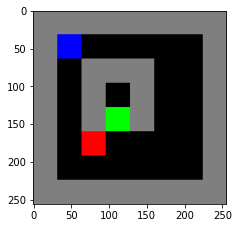

In [22]:
grid_env = GridworldEnv()
env = gnwrapper.LoopAnimation(grid_env)

obs, done = env.reset(), False
rewards = []

# Run one episode
while not done:
    # Sample a random action from the action space
    action = env.action_space.sample()
    next_obs, reward, done, info = env.step(action)
    rewards.append(reward)
    env.render()

env.display()

We can display the rewards collected by the agent.

> Note how the eposide ended when the agent hit the bomb (i.e. `-1.0` reward)

In [23]:
import plotly.express as px
import pandas as pd

df = pd.DataFrame({"reward": rewards})
fig = px.line(df, y="reward", title='Rewards over time', labels=dict(index="Step", reward="Reward"))
fig.show()

I hope you enjoyed this article, feel free to leave a comment or reach out on twitter [@bachiirc](https://twitter.com/bachiirc)